[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1t2HB3RgbMPZJy2IbGO6hEwCdQvLdBmQu#scrollTo=1_JJysiLsCRF)

In [1]:
#Subir credenciales de kaggle , en tu cuenta de kaggle ve a settings -> Create Token 
#Se descargara un archivo .json con tus credenciales
#Ese archivo es el que debes subir en este comando
from google.colab import files 
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felipevasquezu","key":"eb7b2c1020732009b3b57f08a0eacbb3"}'}

#**Descargar Datos desde Kaggle**

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c store-sales-time-series-forecasting


100% 21.4M/21.4M [00:01<00:00, 32.1MB/s]
100% 21.4M/21.4M [00:01<00:00, 20.1MB/s]


In [7]:
! unzip store-sales-time-series-forecasting.zip

Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [8]:
! rm store-sales-time-series-forecasting.zip
! rm kaggle.json

# **Data**

In [9]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 40.1 MB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import plotly.express as px 
import statsmodels.api as sm 
import warnings
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
from pmdarima import auto_arima
import time
from multiprocessing import Pool,cpu_count
warnings.filterwarnings("ignore", category=UserWarning)

In [11]:
path=''
# Load train
train_df = pd.read_csv(path+'train.csv', parse_dates=['date'], infer_datetime_format=True) # columna date a tipo fecha
# Load Test
test_df = pd.read_csv(path+'test.csv', parse_dates=['date'], infer_datetime_format=True) # columna date a tipo fecha
#Load stores
store_df = pd.read_csv(path+'stores.csv')
#Load oil 
oil_df = pd.read_csv(path+'oil.csv',parse_dates=['date'], infer_datetime_format=True)
#Load holidays
holiday_df= pd.read_csv(path+'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
#Load transactions
transaction_df = pd.read_csv(path+'transactions.csv', parse_dates=['date'], infer_datetime_format=True)

# **FUNCIONES**

In [12]:
def create_lags_by_column(df,num_lags,column):
  new_df =  pd.DataFrame(columns=df.columns)
  for y in range(1,55):
    current_df = df[df['store_nbr']== y ]
    for i in range(1,num_lags+1 ):
      current_df[f'lag_{column}_{i}'] = current_df[column].shift(i)

    current_df.dropna(inplace=True)
    current_df.reset_index(inplace=True)
    new_df = pd.concat([new_df, current_df], axis=0, ignore_index=True)
  return new_df

In [13]:
def create_date_features(main_df):
  def get_date_features(df):
    df.loc[:,'day'] = df.date.dt.day
    df.loc[:,'month'] = df.date.dt.month.astype(int)
    df.loc[:,'day_of_week'] = (df.date.dt.dayofweek + 1).astype(int)
    df.loc[:,'year'] = df.date.dt.year.astype(int)
    df.loc[:,"is_wknd"] = (df.date.dt.weekday // 4).astype(int)
    df.loc[:,'week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype(int)
    df.loc[:,'is_month_start'] = df.date.dt.is_month_start.astype(int)
    df.loc[:,'is_month_end'] = df.date.dt.is_month_end.astype(int)
    df.loc[:,'is_year_start'] = df.date.dt.is_year_start.astype(int)
    df.loc[:,'is_year_end'] = df.date.dt.is_year_end.astype(int)
    return df
  pd.options.mode.chained_assignment = None
  main_df = get_date_features(main_df)
  main_df.loc[:,"wageday"] = pd.Series(np.where((main_df['is_month_end'] == 1) | (main_df["day"] == 15), 1, 0)).astype(int)
  return main_df

In [14]:
def create_main_df2(df,oil,transaction,holiday,num_sales_lags,num_oil_lags,num_trans_lags):
  def create_holidays(df,holidays):
    #Creando Holidays 

    holiday = holidays[holidays['transferred'] == False].copy()
    holiday.rename(columns = {'type':'holiday_type'},inplace=True)
    holiday.drop(['transferred', 'description'], axis=1, inplace=True)

    #Festivos nacionales ( aplica a todas las tiendas)
    national_holidays = holiday[holiday['locale'] == 'National'][['date','holiday_type']].copy()
    national_holidays.rename(columns = {'holiday_type':'national_holiday_type'},inplace=True)
    national_holidays
    national_holidays.drop_duplicates(subset='date', keep="first", inplace=True)

    #Festivos de estados 
    state_holidays = holiday[holiday['locale'] == 'Regional'][['date','locale_name','holiday_type']].copy()
    state_holidays.rename(columns = {'locale_name':'state','holiday_type':'state_holiday_type'},inplace=True)
    state_holidays

    #Festivos por ciudad 
    city_holidays = holiday[holiday['locale'] == 'Local'][['date','locale_name','holiday_type']].copy()
    city_holidays.rename(columns = {'locale_name':'city','holiday_type':'city_holiday_type'},inplace=True)

    #Merge
    df = pd.merge(df, national_holidays, how='left', on=['date']) 
    df = pd.merge(df, state_holidays, how='left', on=['date','state']) 
    df = pd.merge(df, city_holidays, how='left', on=['date','city']) 

    #Convirtiendo columnas holidays a binarias 
    df.loc[df['national_holiday_type'].notna(), 'national_holiday_type'] = 1
    df.loc[df['national_holiday_type'].isna(), 'national_holiday_type'] = 0
    df['national_holiday_type'] =df['national_holiday_type'].astype(int)

    df.loc[df['state_holiday_type'].notna(), 'state_holiday_type'] = 1
    df.loc[df['state_holiday_type'].isna(), 'state_holiday_type'] = 0
    df['state_holiday_type'] =df['national_holiday_type'].astype(int)


    df.loc[df['city_holiday_type'].notna(), 'city_holiday_type'] = 1
    df.loc[df['city_holiday_type'].isna(), 'city_holiday_type'] = 0
    df['city_holiday_type'] =df['national_holiday_type'].astype(int)

    #Eliminado duplicados
    dup = df[['date','store_nbr']].duplicated()
    df.drop(index=df[dup].index,inplace=True)

    return df
  
  def create_oil(df,oil):
    oil_data = oil.copy()
    oil_data['dcoilwtico'] = oil_data['dcoilwtico'].fillna(oil_data['dcoilwtico'].rolling(3, min_periods=1).mean())
    oil_data = oil_data.rename(columns={'dcoilwtico': 'oil_price'})
    oil_data.loc[0,'oil_price']=oil_data.loc[1,'oil_price'] #setting first oil price
    df= pd.merge(df,oil_data,on='date',how='left')
    df['oil_price'].fillna(df['oil_price'].rolling(3, min_periods=1).mean(),inplace=True)
    return df

  df_main = df.copy()
  df_main.drop(['family'],axis=1,inplace=True)
  df_main = df_main.groupby(['date','store_nbr']).sum()[['sales','onpromotion']].reset_index()

  #Date features 
  create_date_features(df_main)

  #Transactions
  df_tran = transaction_df.groupby(['date','store_nbr']).sum().reset_index()
  df_main =  pd.merge(df_main,df_tran, on=['date','store_nbr'],how='left')
  df_main['transactions'].fillna(0,inplace=True)

  #Stores
  df_main = pd.merge(df_main,store_df, on='store_nbr',how='left')
  
  #Holidays
  df_main = create_holidays(df_main,holiday)

  #sorting DF 
  df_main = df_main.sort_values(['store_nbr','date'])

  #Merge Oil
  df_main = create_oil(df_main,oil)

  #Corregir los datos de la tienda 52
  sales_8=df_main[(df_main['store_nbr']==8) &(df_main['date']<'2017-04-20')].sales.values
  onpromo_50=df_main[(df_main['store_nbr']==50) & (df_main['date']<'2017-04-20')].onpromotion.values
  trans_34=df_main[(df_main['store_nbr']==34) & (df_main['date']<'2017-04-20')].transactions.values

  df_main['sales'].loc[(df_main['store_nbr']==52) & (df_main['date']<'2017-04-20')]=sales_8
  df_main['onpromotion'].loc[(df_main['store_nbr']==52) & (df_main['date']<'2017-04-20')]=onpromo_50
  df_main['transactions'].loc[(df_main['store_nbr']==52) & (df_main['date']<'2017-04-20')]=trans_34

  #Creating Lags 


  #Creating Lags 
  if num_sales_lags>0 :
    df_main = create_lags_by_column(df_main,num_sales_lags,'sales')
    df_main = df_main.drop(columns=['index'])
  
  if num_oil_lags>0 :
    df_main = create_lags_by_column(df_main,num_oil_lags,'oil_price')
    df_main = df_main.drop(columns=['index'])
    
  if num_trans_lags>0 :
    df_main = create_lags_by_column(df_main,num_trans_lags,'transactions')
    df_main = df_main.drop(columns=['index'])

  #Deleting unecesary columns
  df_main = df_main.drop(columns=['city','state','cluster','type'])
  #converting columns to int
  columns_object = ['store_nbr','onpromotion','day','month','day_of_week','year'
  ,'is_wknd','week_of_month','is_month_start'
  ,'is_month_end','is_year_start','is_year_end','wageday','national_holiday_type'
  ,'state_holiday_type','city_holiday_type']
  df_main[columns_object] = df_main[columns_object].apply(pd.to_numeric, errors='coerce', downcast='integer')


  return df_main

In [15]:
def plot_learning_curve_arima(X, y, arima_params, train_sizes, cv, scoring):
    train_scores = []
    test_scores = []

    for train_size in train_sizes:
        train_subset = int(train_size * len(X))
        X_train_subset = X[:train_subset]
        y_train_subset = y[:train_subset]

        train_scores_subset = []
        test_scores_subset = []

        for _ in range(cv):
            # Fit the ARIMA model
            arima_model = sm.tsa.SARIMAX(endog=y_train_subset, order=arima_params)
            arima_model_fit = arima_model.fit()

            # Calculate scores
            train_score = scoring(y_train_subset, arima_model_fit.predict())
            test_score = scoring(y, arima_model_fit.predict(start=0, end=len(X)-1))

            train_scores_subset.append(train_score)
            test_scores_subset.append(test_score)

        train_scores.append(np.mean(train_scores_subset))
        test_scores.append(np.mean(test_scores_subset))

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores, 'o-',label='Train error',color='r')
    plt.plot(train_sizes, test_scores, 'o-' ,label='Test error',color='g')
    plt.xlabel('Training Set Size')
    plt.ylabel('Root Mean Squared Logarithm Error')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [16]:
def frmsle(y_true, y_pred):
  return  np.sqrt(mean_squared_log_error( y_true, y_pred ))

# **MODELO**

## **Creacion de train y test**

In [17]:
# Separar train data en datos de entrenamiento y test
train_data = train_df[train_df["date"]<="2017-03-01"]
test_data = train_df[train_df["date"]>"2017-03-01"]

In [18]:
main_df_train = create_main_df2(train_data,oil_df,transaction_df,holiday_df,7,5,3)
main_df_test = create_main_df2(test_data,oil_df,transaction_df,holiday_df,7,5,3)

## **Búsqueda de los mejores hiperparametros para SARIMAX (Opcional- Analisis)**

En este primer acercamiento para conocer el modelo vamos a probar el modelo SARIMAX con una sola tienda y solo con la variable endogena ( variable a predecir ) para saber que tanto mejora el rendimiento del modelo cuando se agrega los demas datos del dataset como variables exogenas 

### **SARIMAX Con variable endogena**

In [19]:
store= 7
main_df_train_filtered = main_df_train[main_df_train['store_nbr']==store]
main_df_test_filtered = main_df_test[main_df_test['store_nbr']==store]

columns_serie = main_df_train_filtered.columns.values
columns_serie = np.delete(columns_serie,[0,1,2]) #Deleted date and sales and store which is the constant

Xtrain = main_df_train_filtered.loc[:,columns_serie]
Ytrain = main_df_train_filtered.loc[:,'sales']
Xtest = main_df_test_filtered.loc[:,columns_serie]
Ytest = main_df_test_filtered.loc[:,'sales']


Se utiliza auto_arima para encontrar los mejores parametros para el modelo sarimax segun los datos de entrenamiento 

In [20]:

auto_arima(Ytrain,trace=True,n_jobs=-1).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=28000.657, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28702.404, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28105.167, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28029.458, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28700.434, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28011.876, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27958.652, Time=0.88 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28031.343, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28089.448, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=27950.372, Time=1.00 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=28074.905, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=27737.285, Time=1.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=27876.973, Time=0.38 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=27844.617, Time=3.97 sec
 ARIMA(4,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1502
Model:               SARIMAX(4, 1, 3)   Log Likelihood              -13767.458
Date:                Sun, 28 May 2023   AIC                          27550.915
Time:                        22:20:35   BIC                          27593.426
Sample:                             0   HQIC                         27566.752
                               - 1502                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3154      0.026    -50.885      0.000      -1.366      -1.265
ar.L2         -0.2287      0.053     -4.326      0.000      -0.332      -0.125
ar.L3          0.2934      0.050      5.845      0.000       0.195       0.392
ar.L4         -0.0945      0.023     -4.159      0.000      -0.139      -0.050
ma.L1          0.8070      0.021     37.582      0.000       0.765       0.849
ma.L2         -0.5235      0.033    -15.953      0.000      -0.588      -0.459
ma.L3         -0.6963      0.022    -32.326      0.000      -0.739      -0.654
sigma2      5.752e+06   1.42e-08   4.05e+14      0.000    5.75e+06    5.75e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11910.40
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.54   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.89e+29. Standard errors may be unstable.
"""

In [21]:
# Se crea el modelo SARIMAX con los mejores hyperparametros encontrados en el paso anterior 
model = sm.tsa.SARIMAX(Ytrain,order=(4,1,3)).fit()


In [22]:
start = len(Ytrain) # indice de inicio de la prediccion
end = len(Ytrain)+ len(Ytest) -1 #Indice final de la prediccion 
y_pred = model.predict(start,end)

In [23]:
#Puntaje metrica de error 
y_pred = np.clip(y_pred,a_min=0,a_max=None)
rmsle_test =np.sqrt(mean_squared_log_error(Ytest, y_pred))
print("RMSLE Test ARIMA : %.3f"%rmsle_test)

RMSLE Test ARIMA : 0.183


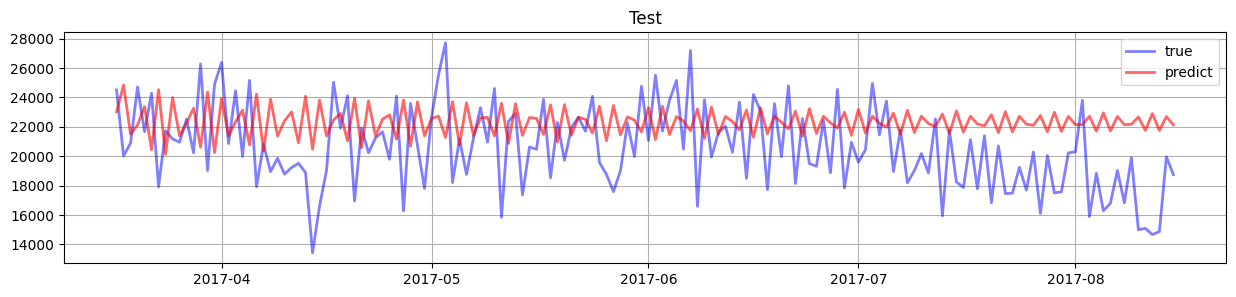

In [24]:
plt.figure(figsize=(15,3))
plt.plot(main_df_test_filtered['date'], main_df_test_filtered['sales'], color="blue", lw=2, label="true", alpha=.5)
plt.plot(main_df_test_filtered['date'], y_pred, color="red", lw=2, label="predict", alpha=.6)
plt.title("Test")
plt.grid();
plt.legend();

### **SARIMAX con variable endogena y exogena**

Ahora evaluaremos el modelo con todas las columnas , incluiremos las variables exogenas para comparar el rendimiento con el resultado anterior 

In [25]:
store= 7
main_df_train_filtered = main_df_train[main_df_train['store_nbr']==store]
main_df_test_filtered = main_df_test[main_df_test['store_nbr']==store]

columns_serie = main_df_train_filtered.columns.values
columns_serie = np.delete(columns_serie,[0,1,2]) #Deleted date and sales and store which is the constant

Xtrain = main_df_train_filtered.loc[:,columns_serie]
Ytrain = main_df_train_filtered.loc[:,'sales']
Xtest = main_df_test_filtered.loc[:,columns_serie]
Ytest = main_df_test_filtered.loc[:,'sales']

In [26]:
#Busqueda de mejores hiperparametros para SARIMAX con variables exogenas
auto_a = auto_arima(Ytrain,exogenous = Xtrain ,trace=True,n_jobs=-1,scoring=frmsle,start_p = 1, start_q = 1, 
                      max_p = 3, max_q = 3)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28031.343, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28702.404, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28105.167, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28029.458, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28700.434, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=28050.182, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28011.876, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=28000.657, Time=1.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27958.652, Time=1.89 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28089.448, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=27950.372, Time=1.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=28074.905, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=27944.598, Time=1.97 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=27562.225, Time=1.40 sec
 ARIMA(2,1,3)(0,0,0

In [27]:
model  = sm.tsa.SARIMAX(Ytrain,order=auto_a.get_params()['order'],exog=Xtrain).fit()

In [28]:
#Prediccion 
start = len(Ytrain)
end = len(Ytrain)+ len(Ytest) -1
y_pred = model.predict(start, end,exog=Xtest)

In [29]:
#Puntaje metrica de error 
y_pred = np.clip(y_pred,a_min=0,a_max=None)
rmsle_test =np.sqrt(mean_squared_log_error(Ytest, y_pred))
print("RMSLE Test ARIMA : %.3f"%rmsle_test)

RMSLE Test ARIMA : 0.334


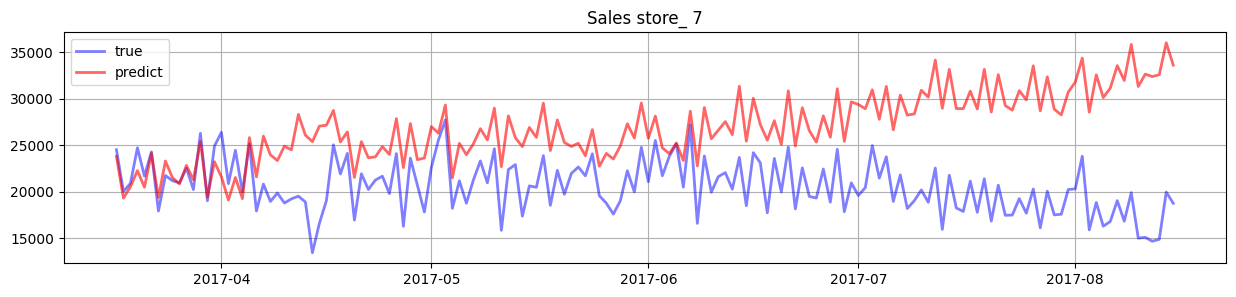

In [31]:
plt.figure(figsize=(15,3))
plt.plot(main_df_test_filtered['date'], main_df_test_filtered['sales'], color="blue", lw=2, label="true", alpha=.5)
plt.plot(main_df_test_filtered['date'], y_pred, color="red", lw=2, label="predict", alpha=.6)
plt.title("Sales store_ 7")
plt.grid();
plt.legend();

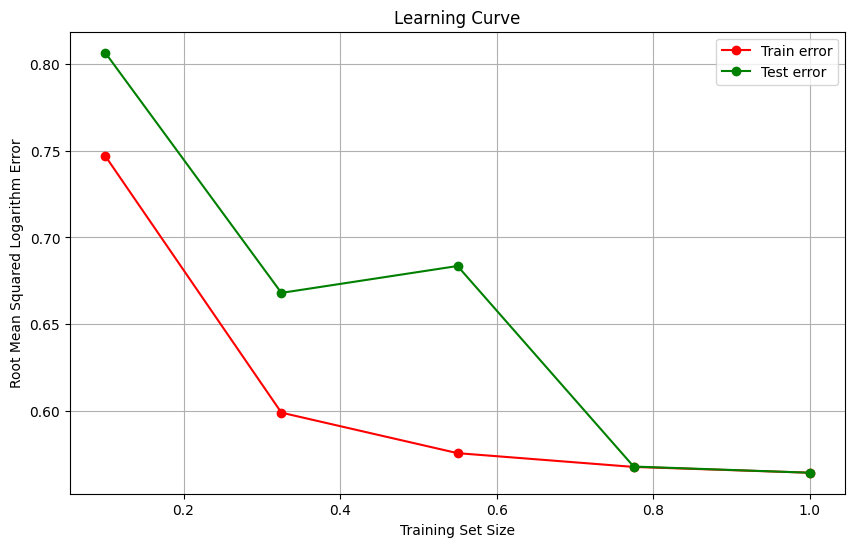

In [32]:
arima_params = auto_a.get_params()['order']

# Define the range of training set sizes
train_sizes = np.linspace(0.1, 1.0, 5)

# Plot the learning curve for ARIMA
plot_learning_curve_arima(Xtrain, Ytrain, arima_params, train_sizes, cv=5, scoring=frmsle)

## **Hiperparametros para el dataset Completo (Opcional)**

In [ ]:
#se obtiene X y de todo el dataset de train y test

columns_serie = main_df_train.columns.values
columns_serie = np.delete(columns_serie,[0,1,2]) #Deleted date and sales and store which is the constant

Xtrain = main_df_train.loc[:,columns_serie]
Ytrain = main_df_train.loc[:,'sales']
Xtest = main_df_test.loc[:,columns_serie]
Ytest = main_df_test.loc[:,'sales']

Sabemos que tenemos una autocorrelacion en la variable sales de 7 , lo que nos ha indicado que el modelo puede funcionar mejor con un lag en sales de 7 dias , este corresponde al parametro P , buscaremos los mejores valores para  q 

In [ ]:
#Busqueda de mejores hiperparametros para SARIMAX con variables exogenas
auto_a = auto_arima(Ytrain,exogenous = Xtrain ,trace=True,scoring=frmsle,start_p=7,max_p=7,d=0
                     , max_q = 3)

Performing stepwise search to minimize aic
 ARIMA(7,0,2)(0,0,0)[0] intercept   : AIC=29520.471, Time=4.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=30309.859, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=29965.365, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=30083.169, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32908.114, Time=0.06 sec
 ARIMA(6,0,2)(0,0,0)[0] intercept   : AIC=29544.028, Time=1.81 sec
 ARIMA(7,0,1)(0,0,0)[0] intercept   : AIC=29522.928, Time=0.95 sec
 ARIMA(7,0,3)(0,0,0)[0] intercept   : AIC=29521.599, Time=3.74 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=29547.285, Time=0.76 sec
 ARIMA(6,0,3)(0,0,0)[0] intercept   : AIC=29531.353, Time=1.45 sec
 ARIMA(7,0,2)(0,0,0)[0]             : AIC=29533.870, Time=2.20 sec

Best model:  ARIMA(7,0,2)(0,0,0)[0] intercept
Total fit time: 15.724 seconds


In [ ]:
auto_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1502
Model:               SARIMAX(7, 1, 1)   Log Likelihood              -13011.493
Date:                Sun, 28 May 2023   AIC                          26040.986
Time:                        03:12:34   BIC                          26088.811
Sample:                             0   HQIC                         26058.802
                               - 1502                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2946      0.145     -2.034      0.042      -0.579      -0.011
ar.L2         -0.3739      0.103     -3.636      0.000      -0.575      -0.172
ar.L3         -0.3985      0.102     -3.893      0.000      -0.599      -0.198
ar.L4         -0.3929      0.109     -3.615      0.000      -0.606      -0.180
ar.L5         -0.3630      0.108     -3.352      0.001      -0.575      -0.151
ar.L6         -0.2205      0.099     -2.224      0.026      -0.415      -0.026
ar.L7          0.3240      0.078      4.163      0.000       0.171       0.477
ma.L1         -0.4024      0.144     -2.786      0.005      -0.686      -0.119
sigma2      1.987e+06    3.3e+04     60.185      0.000    1.92e+06    2.05e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             22687.81
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               4.70   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **Entrenamiento , prediccion y curva de aprendizaje para todas las tiendas**

Se crea un modelo para cada tienda con los hiperparametros encontrados en el paso anterior  , teniendo en cuenta que tenemos 54 tiendas y cada tienda tiene un modelo diferente , este proceso puede tardar 20 minutos .

In [33]:
tiendas = np.empty(55,dtype=object)
for i in range(1,55):
  #Creando Xtrain,Ytrain,Xtest,Ytest
  train_filtered = main_df_train[main_df_train['store_nbr']==i]
  test_filtered = main_df_test[main_df_test['store_nbr']==i]

  columns_serie = train_filtered.columns.values
  columns_serie = np.delete(columns_serie,[0,2]) #Deleted date and sales 

  Xtrain = train_filtered.loc[:,columns_serie]
  Ytrain = train_filtered.loc[:,'sales']
  Xtest = test_filtered.loc[:,columns_serie]
  Ytest = test_filtered.loc[:,'sales']


  #Crear nuevo modelo con los mejores hiperparametros
  model = sm.tsa.SARIMAX(endog=Ytrain,order=(7,0,2),exog=Xtrain).fit()

  #prediccion
  start = len(Ytrain)
  end = len(Ytrain)+ len(Ytest) -1
  y_pred = model.predict(start, end,exog=Xtest)

  #Puntaje metrica de error 
  y_pred = np.clip(y_pred,a_min=0,a_max=None)
  rmsle_test =np.sqrt(mean_squared_log_error(Ytest, y_pred))
  print("RMSLE tienda %d : %.3f"% (i,rmsle_test))

  tienda = {
      'tienda_id':i,
      'y_pred': y_pred,
      'rmsle':rmsle_test,
      'xtrain':Xtrain
  }

  tiendas[i] = tienda

RMSLE tienda 1 : 0.143
RMSLE tienda 2 : 0.131
RMSLE tienda 3 : 0.100
RMSLE tienda 4 : 0.119
RMSLE tienda 5 : 0.089
RMSLE tienda 6 : 0.106
RMSLE tienda 7 : 0.103
RMSLE tienda 8 : 0.103
RMSLE tienda 9 : 0.132
RMSLE tienda 10 : 0.112
RMSLE tienda 11 : 0.107
RMSLE tienda 12 : 0.101
RMSLE tienda 13 : 0.112
RMSLE tienda 14 : 0.131
RMSLE tienda 15 : 0.089
RMSLE tienda 16 : 0.245
RMSLE tienda 17 : 0.118
RMSLE tienda 18 : 0.148
RMSLE tienda 19 : 0.117
RMSLE tienda 20 : 0.149
RMSLE tienda 21 : 0.176
RMSLE tienda 22 : 0.127
RMSLE tienda 23 : 0.107
RMSLE tienda 24 : 0.091
RMSLE tienda 25 : 0.139
RMSLE tienda 26 : 0.233
RMSLE tienda 27 : 0.113
RMSLE tienda 28 : 0.150
RMSLE tienda 29 : 0.130
RMSLE tienda 30 : 0.288
RMSLE tienda 31 : 0.130
RMSLE tienda 32 : 0.342
RMSLE tienda 33 : 0.156
RMSLE tienda 34 : 0.074
RMSLE tienda 35 : 0.212
RMSLE tienda 36 : 0.114
RMSLE tienda 37 : 0.093
RMSLE tienda 38 : 0.131
RMSLE tienda 39 : 0.130
RMSLE tienda 40 : 0.136
RMSLE tienda 41 : 0.137
RMSLE tienda 42 : 0.099
R

Text(0, 0.5, 'RMSLE en test')

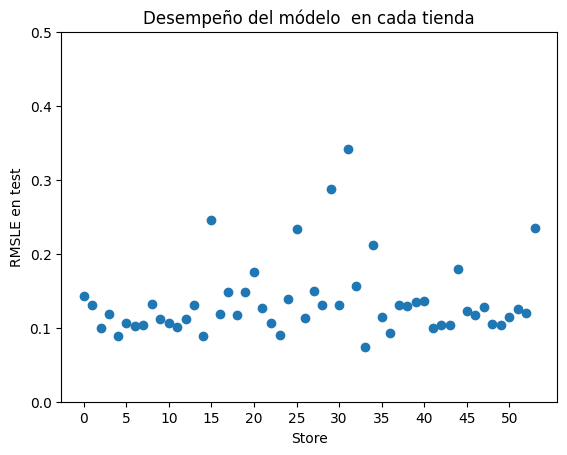

In [34]:
store_id=np.arange(1,55)
scores_tienda=np.zeros(55)
for i in store_id:
  scores_tienda[i]=tiendas[i]['rmsle']
scores_tienda=scores_tienda[1:]
plt.scatter(np.arange(len(scores_tienda)),scores_tienda)
plt.ylim([0, 0.5])
plt.xticks(np.arange(0,55,5))
plt.title('Desempeño del módelo  en cada tienda')
plt.xlabel("Store")
plt.ylabel("RMSLE en test")

In [35]:
print('RSMLE max=', "%.4f" % max(scores_tienda))
print('RSMLE min=', "%.4f" % min(scores_tienda))
print('RSMLE promedio=', "%.4f" % np.mean(scores_tienda))

RSMLE max= 0.3420
RSMLE min= 0.0736
RSMLE promedio= 0.1356


In [ ]:
# Grafica real vs prediccion
fig, axes = plt.subplots(18, 3, figsize = (20,50))
for i in range(1,55):
  #Calcular posicion de la grafica
  row, col = divmod(i - 1, 3)
  ax = axes[row, col]
  #filtrar tienda
  test_filtered = main_df_test[main_df_test['store_nbr']==i]
  #Grafica
  ax.plot(test_filtered['date'], test_filtered['sales'], color="blue", lw=2, label="true", alpha=.5)
  ax.plot(test_filtered['date'], tiendas[i]['y_pred'], color="red", lw=2, label="predict", alpha=.6)
  ax.set_title("store "+ str(i))
  ax.legend(loc='best')
  ax.grid()
  
plt.legend()
plt.tight_layout(pad=3)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Funcion que permite calcular el score de test y train para graficar la curva de
# aprendizaje en el siguiente paso 
def process_learning_curve_arima(i,X, y, arima_params, train_sizes, cv, scoring):
    mensaje = ("Procesando tienda "+ str(i))
    print('\r'+mensaje)
    train_scores = []
    test_scores = []

    for train_size in train_sizes:
        train_subset = int(train_size * len(X))
        X_train_subset = X[:train_subset]
        y_train_subset = y[:train_subset]

        train_scores_subset = []
        test_scores_subset = []

        for _ in range(cv):
            # Fit the ARIMA model
            arima_model = sm.tsa.SARIMAX(endog=y_train_subset, order=arima_params)
            arima_model_fit = arima_model.fit()

            # Calculate scores
            train_pred = arima_model_fit.predict()
            train_pred = np.clip(train_pred,a_min=0,a_max=None)
            train_score = scoring(y_train_subset,train_pred)

            test_pred = arima_model_fit.predict(start=0, end=len(X)-1)
            test_pred = np.clip(test_pred,a_min=0,a_max=None)
            test_score = scoring(y, test_pred)

            train_scores_subset.append(train_score)
            test_scores_subset.append(test_score)

        train_scores.append(np.mean(train_scores_subset))
        test_scores.append(np.mean(test_scores_subset))
    score ={'tienda':i,
        'train':train_scores,
        'test':test_scores,
        'sizes':train_sizes}

    return score

In [ ]:
from joblib import Parallel, delayed
# Funcion que permite calcular el score de test y train para graficar la curva de
# aprendizaje en el siguiente paso 
def process_learning_curve_arima2(i,X, y, arima_params, train_sizes, cv, scoring):
    mensaje = ("Procesando tienda "+ str(i))
    print('\r'+mensaje)
    train_scores = []
    test_scores = []
    def process_trainsize(train_size,X,y,arima_params):

      train_subset = int(train_size * len(X))
      X_train_subset = X[:train_subset]
      y_train_subset = y[:train_subset]

      train_scores_subset = []
      test_scores_subset = []

      for _ in range(cv):
          # Fit the ARIMA model
          arima_model = sm.tsa.SARIMAX(endog=y_train_subset, order=arima_params)
          arima_model_fit = arima_model.fit()

          # Calculate scores
          train_pred = arima_model_fit.predict()
          train_pred = np.clip(train_pred,a_min=0,a_max=None)
          train_score = scoring(y_train_subset,train_pred)

          test_pred = arima_model_fit.predict(start=0, end=len(X)-1)
          test_pred = np.clip(test_pred,a_min=0,a_max=None)
          test_score = scoring(y, test_pred)

          train_scores_subset.append(train_score)
          test_scores_subset.append(test_score)

      return np.mean(train_scores_subset),np.mean(test_scores_subset)
    
    scores = Parallel(n_jobs=3)(delayed(process_trainsize)(size,X,y,arima_params) for size in train_sizes)
    train_scores_subset,test_scores_subset = zip(*scores)
    score ={'tienda':i,
    'train':train_scores_subset,
    'test':test_scores_subset,
    'sizes':train_sizes}

    return score

Ejecucion en paralelo del calculo de scores para  las graficas de curva de aprendizaje, este proceso puede tardar 35 minutos 

In [ ]:
#Ejecucion en paralelo del calculo de scores para  las graficas de curva de aprendizaje 
learning_scores=np.empty(55, dtype=object)

def update_progress_curve(score):
  learning_scores[score['tienda']]=score


# Crea un pool de workers 
pool2 = Pool(5) # numero de procesos en paralelo
arima_params = (7,0,2)
# Define the range of training set sizes
train_sizes = np.linspace(0.1, 1.0, 5)

# Ejecuta las tareas de forma asincrona 
for i in range(1, 55):
  train_filtered = main_df_train[main_df_train['store_nbr']==i]
  pool2.apply_async(process_learning_curve_arima, args=(i,tiendas[i]['xtrain'], train_filtered['sales'], arima_params, train_sizes, 5, frmsle),callback=update_progress_curve)

# Cierra el pool y espera a que todas las tareas terminen
pool2.close()
pool2.join()


Procesando tienda 5
Procesando tienda 2

Procesando tienda 4

Procesando tienda 6
Procesando tienda 7
Procesando tienda 8
Procesando tienda 9
Procesando tienda 10
Procesando tienda 11
Procesando tienda 12
Procesando tienda 13
Procesando tienda 14
Procesando tienda 15
Procesando tienda 16
Procesando tienda 17
Procesando tienda 18
Procesando tienda 19
Procesando tienda 20
Procesando tienda 21
Procesando tienda 22
Procesando tienda 23
Procesando tienda 24
Procesando tienda 25
Procesando tienda 26
Procesando tienda 27
Procesando tienda 28
Procesando tienda 29
Procesando tienda 30
Procesando tienda 31
Procesando tienda 32
Procesando tienda 33
Procesando tienda 34
Procesando tienda 35
Procesando tienda 36
Procesando tienda 37
Procesando tienda 38
Procesando tienda 39
Procesando tienda 40
Procesando tienda 41
Procesando tienda 42
Procesando tienda 43
Procesando tienda 44
Procesando tienda 45
Procesando tienda 46
Procesando tienda 47
Procesando tienda 48
Procesando tienda 49
Procesando tienda 

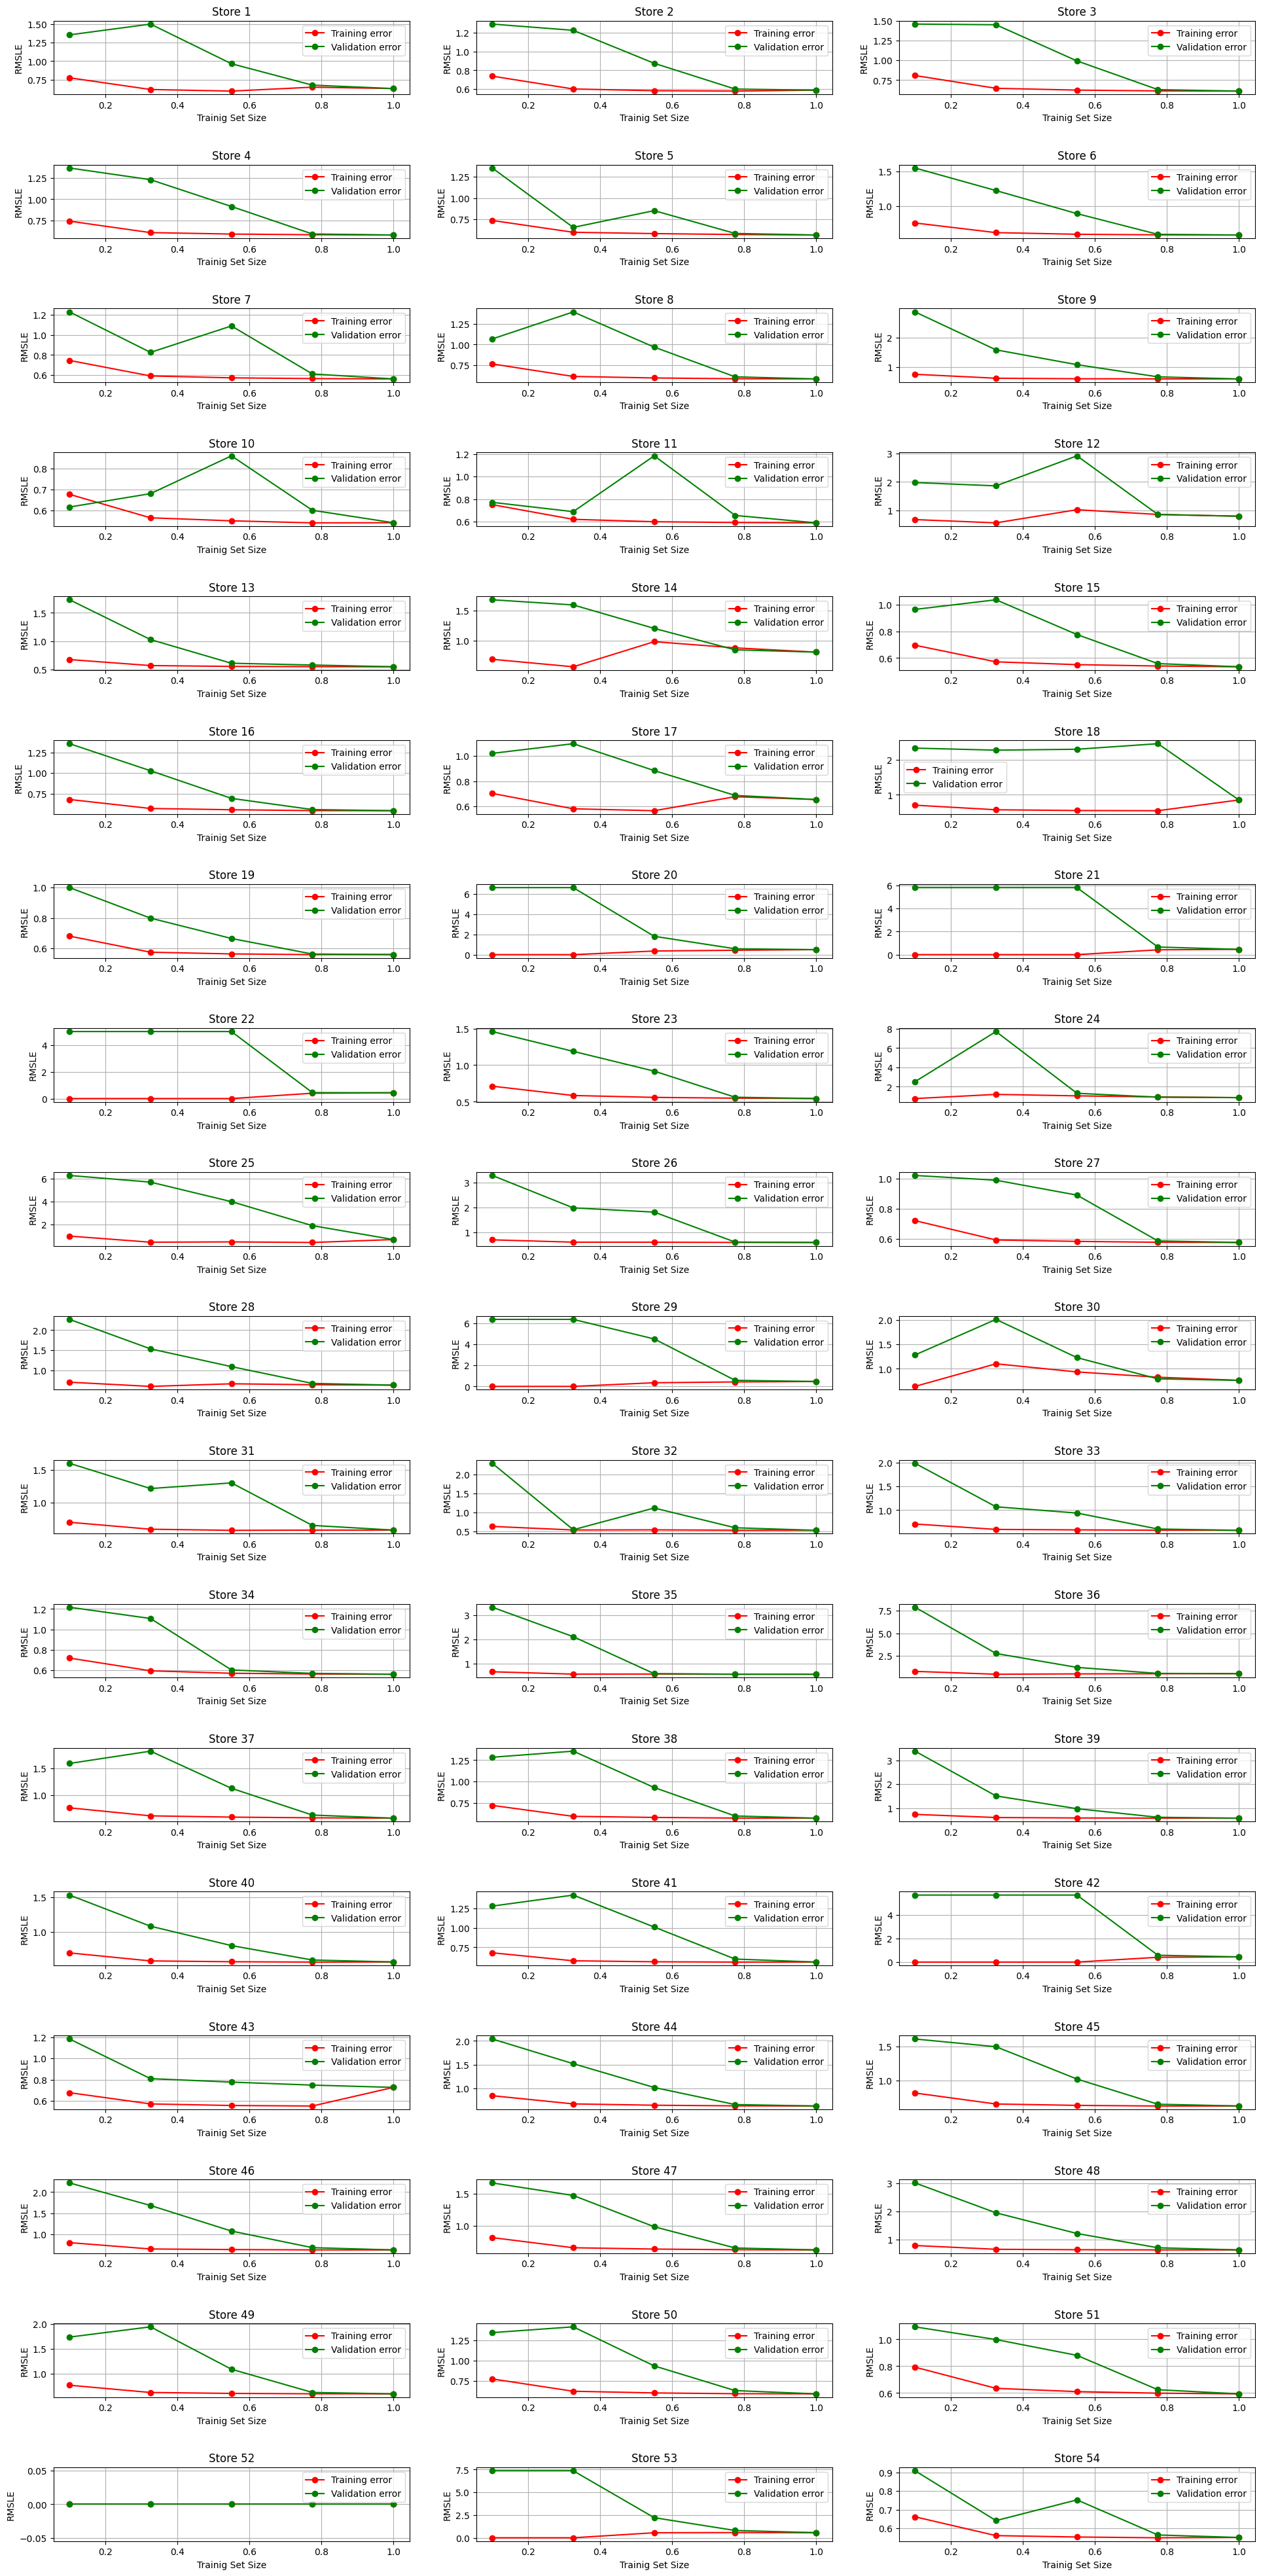

In [ ]:
#Graficando curva de aprendizaje 
fig, axes = plt.subplots(18, 3, figsize = (20,40)) 
for i in range(1,55):
  #Calcular posicion de la grafica
  row, col = divmod(i - 1, 3)
  ax = axes[row, col]

  #consultando scores
  tienda_score = learning_scores[i]
 
  ax.plot(tienda_score['sizes'], tienda_score['train'], 'o-', label='Training error'  , color='r')
  ax.plot(tienda_score['sizes'], tienda_score['test'],  'o-', label='Validation error', color='g')

 
  ax.set_title('Store ' + str(i))
  ax.legend(loc='best')
  ax.grid(True)

  for ax in axes.flat:
    ax.set(xlabel='Trainig Set Size', ylabel='RMSLE')

plt.tight_layout(pad=3)
plt.show()